<span style="color: purple">

Load in stored variables:

</span>

In [6]:
%store -r data_dir sites_gdf siskiyou_forest_gdf padres_forest_gdf

<span style="color: purple">

Import packages:

</span>

In [7]:
# Import necessary packages
import os
from glob import glob
from math import floor, ceil

import earthaccess # Access NASA data from the cloud
import pandas as pd
import matplotlib.pyplot as plt # Overlay pandas and xarray plots
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
import xrspatial

## STEP 2: DATA ACCESS

### Soil data

The [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/) is a
convenient way to uniformly access a variety of soil parameters such as
pH and percent clay in the US. It is available for a range of depths (in
cm) and split into 1x1 degree tiles.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download POLARIS data for a particular location, soil parameter,
and soil depth. Your function should account for the situation where
your site boundary crosses over multiple tiles, and merge the necessary
data together.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include soil parameters that will help you to
answer your scientific question. We recommend using a soil depth that
best corresponds with the rooting depth of your species.</p></div></div>

<span style="color: purple">

I will focus on soil pH. According to the [USDA PLANTS Database](https://plants.usda.gov/plant-profile/SESE3/characteristics), *S. sempervirens* prefer a soil pH of 5.0-7.0. Also, their minimum root depth is 40 inches (~102 cm), so I will focus on soil depths of 100-200 cm.

</span>

In [8]:
#  Define the URL template to download soil data from POLARIS
def soil_url_temp(variable='variable',
                  statistic='statistic',
                  depth='depth'):
    """
    Create a URL template for downloading soil data from POLARIS.

    Parameters
    ----------
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    soil_url_template : str
        Template of the URL to download the soil data.
    """
    soil_url_template = ("http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/"
                    "v1.0"
                    f"/{variable}"
                    f"/{statistic}"
                    f"/{depth}"
                    "/lat{min_lat}{max_lat}"
                    "_lon{min_lon}{max_lon}.tif")
    return soil_url_template

In [9]:
# Define site bounds
def define_site_bounds(site_gdf):
    """
    Identify the bounds of a geographic site.
     
    Specifically, this function creates a tuple with
    a DataArray of the site bounds and the minimum longitude,
    minimum latitude, maximum longitude, and maximum latitude of a site.

    Parameters
    ----------
    site_gdf : GeoDataFrame
        The GeoDataFrame of the site of interest.

    Returns
    -------
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    """
    site_bounds = (site_bounds_min_lon,
                   site_bounds_min_lat,
                   site_bounds_max_lon,
                   site_bounds_max_lat) = (
                       site_gdf
                       .total_bounds)
    return (site_bounds, site_bounds_min_lon, site_bounds_min_lat,
    site_bounds_max_lon, site_bounds_max_lat)

In [10]:
# Process soil DataArrays
def process_soil_da(site_soil_dir,
                    soil_url_template,
                    site_bounds,
                    site_bounds_min_lon,
                    site_bounds_min_lat,
                    site_bounds_max_lon,
                    site_bounds_max_lat,
                    variable='variable',
                    statistic='statistic',
                    depth='depth'):
    """
    Save, open, scale, and crop raster soil data.

    Parameters
    ----------
    site_soil_dir : str
        The directory where the soil data will be saved.
    soil_url_template : str
        Template of the URL to download the soil data.
    site_bounds : DataArray
        A DataArray with the minimum and maximum longitude and
        minimum and maximum latitude of the site.
    site_bounds_min_lon : float
        The minimum longitude of the site.
    site_bounds_min_lat : float
        The minimum latitude of the site.
    site_bounds_max_lon : float
        The maximum longitude of the site.
    site_bounds_max_lat : float
        The maximum latitude of the site.
    variable : str
        The soil `variable` of interest.
    statistic : {'mean', 'mode', 'p5', 'p50', 'p95'}
        The `statistic` type of interest.
    depth : {'0_5', '5_15', '15_30', '30_60', '60_100', or '100_200'}
        The `depth` of interest in cm.

    Returns
    -------
    site_soil_das : list
        A list of DataArrays of soil data for the
        different rasters covering the site of interest.
    """
    site_soil_das = []
    # List out the soil files for download
    for min_lon in range(floor(site_bounds_min_lon),
                         ceil(site_bounds_max_lon)):
        for min_lat in range(floor(site_bounds_min_lat),
                             ceil(site_bounds_max_lat)):
            max_lon = min_lon + 1
            max_lat = min_lat + 1
            soil_url = soil_url_template.format(
                min_lat=min_lat,
                max_lat=max_lat,
                min_lon=min_lon,
                max_lon=max_lon)
            
            # Define file path for saving downloaded raster data
            soil_path = os.path.join(site_soil_dir,
                                     f"soil_{variable}_{statistic}_{depth}"
                                     f"_lat{min_lat}{max_lat}"
                                     f"_lon{min_lon}{max_lon}.tif")

            if not os.path.exists(soil_path):
                # Save raster data to soil path, mask and scale, squeeze
                soil_da = rxr.open_rasterio(
                    soil_url,
                    mask_and_scale=True
                    ).squeeze()
                soil_da.to_netcdf(soil_path)
                print(f'soil_da saved: {soil_path}')
            else:
                print(f'file already exists: {soil_path}')

            # Open and squeeze raster soil data
            soil_da = rxr.open_rasterio(
                soil_url,
                mask_and_scale=True
            ).squeeze()

            # Crop the raster soil data
            cropped_da = soil_da.rio.clip_box(*site_bounds)
            site_soil_das.append(cropped_da)
            print('Cropped')

    return site_soil_das

In [11]:
# Define data directory for the soil data
soil_ph_dir = os.path.join(data_dir, 'soil-ph')

os.makedirs(soil_ph_dir, exist_ok=True)

soil_ph_pattern = os.path.join (soil_ph_dir, '*.tif')
soil_ph_pattern

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\soil-ph\\*.tif'

<span style="color: purple">

#### Load in Siskiyou National Forest soil pH data

</span>

In [12]:
# Define Siskiyou bounds
siskiyou_bounds = define_site_bounds(siskiyou_forest_gdf)

# Check bounds
siskiyou_bounds

(array([-124.41629676,   41.88061609, -123.30873415,   42.8864844 ]),
 np.float64(-124.41629675963702),
 np.float64(41.8806160868663),
 np.float64(-123.30873414962662),
 np.float64(42.886484404653714))

In [13]:
# Create soil pH url template (can be used to load in Los Padres soil data too)
soil_url_template = soil_url_temp(variable='ph', statistic='mean', depth='100_200')

# Check url template
soil_url_template

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/100_200/lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif'

In [14]:
# Process Siskiyou soil pH DataArrays
siskiyou_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                             soil_url_template,
                                             siskiyou_bounds[0],
                                             siskiyou_bounds[1],
                                             siskiyou_bounds[2],
                                             siskiyou_bounds[3],
                                             siskiyou_bounds[4],
                                             variable='ph',
                                             statistic='mean',
                                             depth='100_200')

file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4142_lon-125-124.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4243_lon-125-124.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4142_lon-124-123.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat4243_lon-124-123.tif
Cropped


In [15]:
# Merge Siskiyou soil ph data tiles
siskiyou_soil_ph_da = merge_arrays(siskiyou_soil_ph_indiv_das)

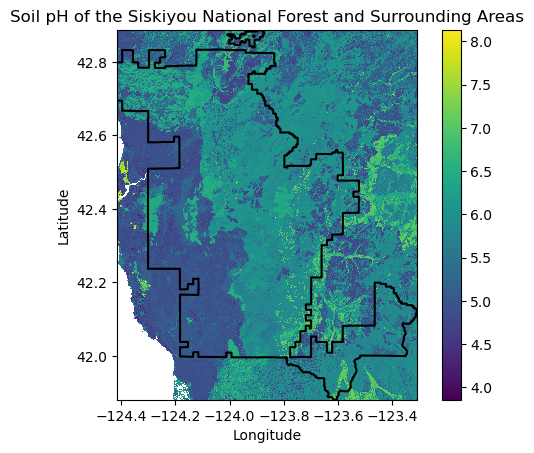

In [16]:
# Plot Siskiyou National Forest on siskiyou_soil_ph_da
siskiyou_soil_ph_da.plot()
siskiyou_forest_gdf.to_crs(siskiyou_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# Add titles and axes to plot
plt.title('Soil pH of the Siskiyou National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<span style="color: purple">

#### Load in Los Padres National Forest soil pH data

</span>

In [17]:
# Define Los Padres bounds
padres_bounds = define_site_bounds(padres_forest_gdf)

# Check bounds
padres_bounds

(array([-121.84915641,   34.3915375 , -118.74267059,   36.40406272]),
 np.float64(-121.8491564113724),
 np.float64(34.391537504483146),
 np.float64(-118.74267058945019),
 np.float64(36.40406272249097))

In [18]:
# Process Los Padres soil pH DataArrays
padres_soil_ph_indiv_das = process_soil_da(soil_ph_dir,
                                             soil_url_template,
                                             padres_bounds[0],
                                             padres_bounds[1],
                                             padres_bounds[2],
                                             padres_bounds[3],
                                             padres_bounds[4],
                                             variable='ph',
                                             statistic='mean',
                                             depth='100_200')

file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3435_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3536_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3637_lon-122-121.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3435_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3536_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soil_ph_mean_100_200_lat3637_lon-121-120.tif
Cropped
file already exists: C:\Users\riede\earth-analytics\data\spring-2025-habitat-suitability\soil-ph\soi

In [19]:
# Merge Los Padres soil ph data tiles
padres_soil_ph_da = merge_arrays(padres_soil_ph_indiv_das)

MemoryError: Unable to allocate 309. MiB for an array with shape (1, 7246, 11184) and data type float32

In [ ]:
# Plot padres National Forest on padres_soil_ph_da
padres_soil_ph_da.plot()
padres_forest_gdf.to_crs(padres_soil_ph_da.rio.crs).boundary.plot(ax = plt.gca(), color='black')

# Add titles and axes to plot
plt.title('Soil pH of the Los Padres National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

### Topographic data

One way to access reliable elevation data is from the [SRTM
dataset](https://www.earthdata.nasa.gov/data/instruments/srtm),
available through the [earthaccess
API](https://earthaccess.readthedocs.io/en/latest/quick-start/).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download SRTM elevation data for a particular location and
calculate any additional topographic variables you need such as slope or
aspect.</p>
<p>Then, use loops to download and organize the rasters you will need to
complete this section. Include topographic parameters that will help you
to answer your scientific question.</p></div></div>

> **Warning**
>
> Be careful when computing the slope from elevation that the units of
> elevation match the projection units (e.g. meters and meters, not
> meters and degrees). You will need to project the SRTM data to
> complete this calculation correctly.

<span style="color: purple">

#### Load in Siskiyou National Forest elevation data

</span>

In [ ]:
# Define data directory for the Siskiyou elevation data
siskiyou_elevation_dir = os.path.join(data_dir, 'siskiyou-elevation-srtm')

os.makedirs(siskiyou_elevation_dir, exist_ok=True)

siskiyou_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm'

In [ ]:
# Log in to earthaccess
earthaccess.login()

# Search earthaccess datasets for SRTM
datasets = earthaccess.search_datasets(keyword='SRTM DEM')
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

NASADEM_SHHP NASADEM SRTM-only Height and Height Precision Mosaic Global 1 arc second V001
NASADEM_SIM NASADEM SRTM Image Mosaic Global 1 arc second V001
NASADEM_SSP NASADEM SRTM Subswath Global 1 arc second V001
C_Pools_Fluxes_CONUS_1837 CMS: Terrestrial Carbon Stocks, Emissions, and Fluxes for Conterminous US, 2001-2016
SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
GEDI01_B GEDI L1B Geolocated Waveform Data Global Footprint Level V002
GEDI02_B GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level V002
NASADEM_HGT NASADEM Merged DEM Global 1 arc second V001
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL30 NASA Shuttle Radar Topography Mission Global 30 arc second V002
SRTMIMGM NASA Shuttle Radar Topography Mission Combined Image Data Set V003
SRTMIMGR NASA Shuttle Radar Topography Mission Swath Image Data V003
GFSAD30EUCEARUM

In [ ]:
# Siskiyou data search
siskiyou_srtm_pattern = os.path.join(siskiyou_elevation_dir, '*.hgt.zip')

# Define siskiyou elevation bounds
siskiyou_elev_bounds = tuple(siskiyou_forest_gdf.total_bounds)

# Add buffer to siskiyou elevation bounds
buffer = .025
siskiyou_xmin, siskiyou_ymin, siskiyou_xmax, siskiyou_ymax = siskiyou_elev_bounds
siskiyou_elev_bounds_buffer = (siskiyou_xmin-buffer,
                               siskiyou_ymin-buffer,
                               siskiyou_xmax+buffer,
                               siskiyou_ymax+buffer)

if not glob(siskiyou_srtm_pattern):
    # Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
    siskiyou_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=siskiyou_elev_bounds_buffer
    )
    # Download SRTM files
    siskiyou_srtm_results = earthaccess.download(
        siskiyou_srtm_search,
        siskiyou_elevation_dir)
else:
    print('SRTM files already downloaded')

# Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
siskiyou_srtm_search = earthaccess.search_data(
    short_name='SRTMGL1',
    bounding_box=siskiyou_elev_bounds_buffer
)
# Download SRTM files
siskiyou_srtm_results = earthaccess.download(
    siskiyou_srtm_search,
    siskiyou_elevation_dir)

# Check siskiyou_srtm_results download
# srtm dataset files are geotiffs but they instead have a .hgt tag (height)
# results are also .zip files
siskiyou_srtm_results

SRTM files already downloaded


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N41W124.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N42W124.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N41W125.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\siskiyou-elevation-srtm\\N42W125.SRTMGL1.hgt.zip']

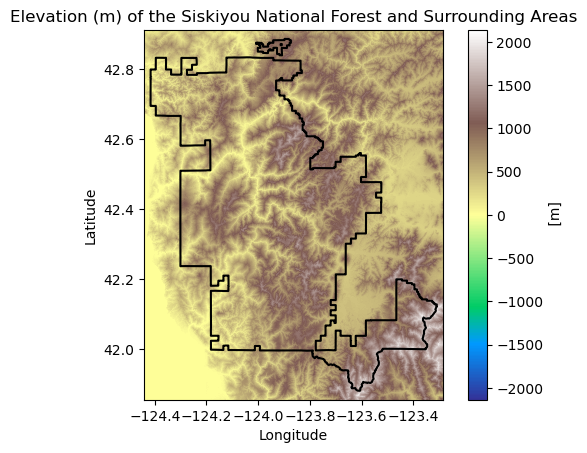

In [ ]:
# Open Siskiyou SRTM files
siskiyou_srtm_da_list = []
for srtm_path in glob(siskiyou_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*siskiyou_elev_bounds_buffer)
    siskiyou_srtm_da_list.append(srtm_cropped_da)
    
# Merge tiles
siskiyou_srtm_da = merge_arrays(siskiyou_srtm_da_list)

# Check SRTM data w/ Siskiyou plotted on top
siskiyou_srtm_da.plot(cmap='terrain')

siskiyou_forest_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Siskiyou National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

<span style="color: purple">

#### Load in Los Padres National Forest elevation data

</span>

In [ ]:
# Define data directory for the Los Padres elevation data
padres_elevation_dir = os.path.join(data_dir, 'padres-elevation-srtm')

os.makedirs(padres_elevation_dir, exist_ok=True)

padres_elevation_dir

'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm'

In [ ]:
# Los Padres data search
padres_srtm_pattern = os.path.join(padres_elevation_dir, '*.hgt.zip')

# Define padres elevation bounds
padres_elev_bounds = tuple(padres_forest_gdf.total_bounds)

# Add .025 buffer to bounds
c_xmin, c_ymin, c_xmax, c_ymax = padres_elev_bounds
padres_elev_bounds_buffer = (c_xmin-buffer,
                            c_ymin-buffer,
                            c_xmax+buffer,
                            c_ymax+buffer)

if not glob(padres_srtm_pattern):
    padres_srtm_search = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box=padres_elev_bounds_buffer
    )
    # Download SRTM files
    padres_srtm_results = earthaccess.download(padres_srtm_search,
                                              padres_elevation_dir)
else:
    print('SRTM files already downloaded.')

# Out of the results above, we'll use: SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
padres_srtm_search = earthaccess.search_data(
    short_name='SRTMGL1',
    bounding_box=padres_elev_bounds_buffer
)
# Download SRTM files
padres_srtm_results = earthaccess.download(padres_srtm_search,
                                            padres_elevation_dir)

# Check padres_srtm_results download
padres_srtm_results

SRTM files already downloaded.


QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

['C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W122.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W122.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N34W120.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N34W121.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N35W119.SRTMGL1.hgt.zip',
 'C:\\Users\\riede\\earth-analytics\\data\\spring-2025-habitat-suitability\\padres-elevation-srtm\\N36W121.SRTMGL1.hgt.zip',


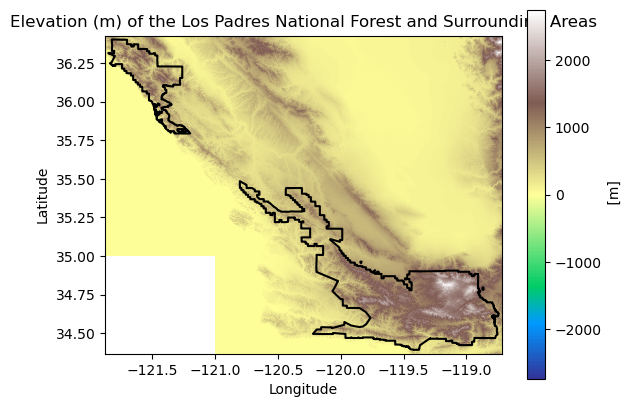

In [ ]:
# Open Los Padres SRTM files
padres_srtm_da_list = []
for srtm_path in glob(padres_srtm_pattern):
    # Open files and put them in a DataArray
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    # Crop DataArrays
    srtm_cropped_da = tile_da.rio.clip_box(*padres_elev_bounds_buffer)
    padres_srtm_da_list.append(srtm_cropped_da)
padres_srtm_da_list

# Merge tiles
padres_srtm_da = merge_arrays(padres_srtm_da_list)

# Check SRTM data w/ padres plotted on top
padres_srtm_da.plot(cmap='terrain')

padres_forest_gdf.boundary.plot(ax = plt.gca(), color='black')
plt.title('Elevation (m) of the Los Padres National Forest and Surrounding Areas')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

### Climate model data

You can use MACAv2 data for historical and future climate data. Be sure
to compare at least two 30-year time periods (e.g. historical vs. 10
years in the future) for at least four of the CMIP models. Overall, you
should be downloading at least 8 climate rasters for each of your sites,
for a total of 16. **You will *need* to use loops and/or functions to do
this cleanly!**.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Write a <strong>function with a numpy-style docstring</strong> that
will download MACAv2 data for a particular climate model, emissions
scenario, spatial domain, and time frame. Then, use loops to download
and organize the 16+ rasters you will need to complete this section. The
<a
href="http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html">MACAv2
dataset is accessible from their Thredds server</a>. Include an
arrangement of sites, models, emissions scenarios, and time periods that
will help you to answer your scientific question.</p></div></div>

In [4]:
# Download climate data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Make sure to include a description of the climate data and how you
selected your models. Include a citation of the MACAv2 data</p></div></div>

YOUR CLIMATE DATA DESCRIPTION AND CITATIONS HERE